In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Linear Interpolation 
def ends_filler(column):
    if  column.dtype.kind in ['i', 'f']:
            column = first_filler(column)
            column = last_filler(column)
    return column

def first_filler(column):
    if pd.isnull(column.at[0]) or np.isnan(column.at[0]):
        size = len(column) -1
        first_valid_index = 0
        while first_valid_index <= size and (pd.isnull(column.at[first_valid_index]) or np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > size:
            column.at[0] = 0.0
        else:
            column.at[0] = column.at[first_valid_index]
    return column
    
def last_filler(column):
    if pd.isnull(column.at[len(column) -1]) or np.isnan(column.at[len(column) -1]):  
        last_valid_index = len(column) -1
        while last_valid_index >= 0 and (pd.isnull(column.at[last_valid_index]) or np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < 0:
            column.at[len(column) -1] = 0.0
        else:
            column.at[len(column) -1] = column.at[last_valid_index]
    return column
    
def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def linear_filler(column):
    if column.isnull().any():
        for i, value in enumerate(column):
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                linear_a = (column.at[end] - column.at[start])/(end - start)
                linear_b = column.at[start] - linear_a*start
                for x in gap:
                    column.at[x] = linear_a*x + linear_b
    return column 


In [14]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = ends_filler(df[col])
                df[col] = linear_filler(df[col]) 
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 2) #2 meses
            i += 1
        return df

In [15]:
df = read_csv_replace_missing_by_polynomial('fgts.csv', 0, 0)
df = df.drop('Apagar', axis=1)
df

,Ano,Fundo de garantia por tempo de serviço (FGTS) (R$)
0,1988-1,1.007931e-02
1,1988-2,1.120321e-02
2,1988-3,1.161839e-02
3,1988-4,1.221780e-02
4,1988-5,1.377387e-02
...,...,...
422,2023-3,1.413268e+07
423,2023-4,1.399974e+07
424,2023-5,1.404264e+07
425,2023-6,1.404037e+07


In [16]:
def format_month_year(df_to_Change):
    df_to_Change['Ano'] = df_to_Change['Ano'].str.split('-').str[0]
    return df_to_Change

df = format_month_year(df)
df['Ano'] = pd.to_numeric(df['Ano'], errors='coerce', downcast='integer')
df_mo_2003 = df[df['Ano'] >= 2003] 
df_mo_2003

,Ano,Fundo de garantia por tempo de serviço (FGTS) (R$)
180,2003,2.097001e+06
181,2003,2.000523e+06
182,2003,1.963278e+06
183,2003,1.954187e+06
184,2003,1.975493e+06
...,...,...
422,2023,1.413268e+07
423,2023,1.399974e+07
424,2023,1.404264e+07
425,2023,1.404037e+07


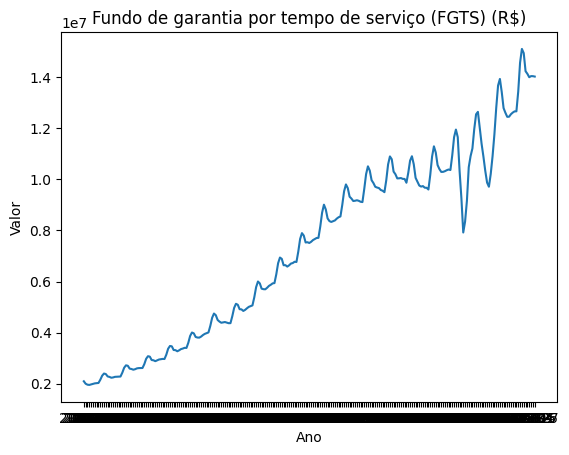

,Fundo de garantia por tempo de serviço (FGTS) (R$)
2003-1,2.097001e+06
2003-2,2.000523e+06
2003-3,1.963278e+06
2003-4,1.954187e+06
2003-5,1.975493e+06
...,...
2023-3,1.413268e+07
2023-4,1.399974e+07
2023-5,1.404264e+07
2023-6,1.404037e+07


In [17]:
import re

def correct_index(df):
    new_index = []
    for i, index_value in enumerate(df.index):
#         corrected_index = re.sub(r'\.\d{1,2}', '', index_value)
        new_index.append(f"{index_value}-{i % 12 + 1}")
    df.index = new_index
    return df

df_mo_2003.set_index('Ano', inplace=True)
df_mo_2003 = correct_index(df_mo_2003)
plot_columns(df_mo_2003)
df_mo_2003

In [18]:
df_mo_2003.to_csv('2003_mo_fgts.csv', index=True)